# 近隣の買い物ができる場所を調査するエージェント

このノートブックでは、LangChain と LangGraph を使って複雑な Agent Workflow を構築します。

## 構築するワークフロー

近隣の買い物ができる場所を調査するエージェント

- ツール: web api 機能付きのモデルを使用して回答を得るツール
- エージェント: 駅近隣のエリアを網羅的に調査。調査は段階的に実行し、ツールのパラメータを変更しながら調査範囲を変更する。パラメータには指定範囲が存在。
- 終了条件: 新規情報が出にくくなる・最大繰り返し数を超えるのいずれかを満たしたと判断した時


In [10]:
# 必要なライブラリのインポート
import os
import json

from typing import List, Dict, Any, Annotated
from dotenv import load_dotenv
from IPython.display import Image

# LangChain imports
from langchain_core.messages import HumanMessage
from langchain_core.prompts import ChatPromptTemplate
from langchain_openai import ChatOpenAI
from langchain_core.tools import tool

# LangGraph imports
from langgraph.graph import StateGraph, END
from langgraph.checkpoint.memory import MemorySaver

# 環境変数読み込み
load_dotenv()

print("📦 ライブラリインポート完了（LangGraph reducer機能追加）")

# API キー確認
OPENAI_API_KEY = os.getenv("OPENAI_API_KEY")

if OPENAI_API_KEY:
    print("✅ OpenAI APIキーが設定されています")
    print("🔍 gpt-5-search-api使用可能")
else:
    print("⚠️ OpenAI APIキーが設定されていません")
    print("💡 OpenAI APIキーの設定方法:")
    print("   1. https://platform.openai.com でアカウント作成")
    print("   2. API Keysセクションで新しいキーを作成")
    print("   3. .envファイルにOPENAI_API_KEY=your_key_hereを追記")

📦 ライブラリインポート完了（LangGraph reducer機能追加）
✅ OpenAI APIキーが設定されています
🔍 gpt-5-search-api使用可能


In [11]:
# State定義 - 適応的ショッピング施設調査エージェント用データ構造（LangGraph reducer機能使用）
from pydantic import BaseModel, Field, ConfigDict
from langgraph.graph import MessagesState


# LangGraph用のカスタムreducer関数（説明文付き）
def merge_survey_history(existing: List, new: List) -> List:
    """各回の調査サマリー履歴を結合する"""
    return existing + new


def merge_areas(existing: List, new: List) -> List:
    """発見したショッピング施設エリアのリストを結合する"""
    return existing + new


def merge_errors(existing: List, new: List) -> List:
    """処理エラーのリストを結合する"""
    return existing + new


# ショッピング施設情報のPydanticモデル
class ShoppingFacility(BaseModel):
    model_config = ConfigDict(from_attributes=True)

    name: str = Field(..., description="店舗名")
    category: str = Field(..., description="業態カテゴリ（例：ファッション、家電など）")
    walking_minutes: int = Field(..., description="駅からの徒歩時間（分）")
    location: str = Field(..., description="具体的な場所・住所")
    area_name: str = Field(..., description="所属するエリア名（商業施設名など）")
    features: List[str] = Field(..., description="特徴・売りポイント")
    price_range: str = Field(..., description="価格帯（低/中/高）")
    business_hours: str = Field(..., description="営業時間")
    sns_appeal_points: List[str] = Field(..., description="SNSアピールポイント（映えるポイント、話題性など）")
    source_url: str = Field(default="", description="情報源URL")


# エリア情報の集約モデル
class ShoppingArea(BaseModel):
    model_config = ConfigDict(from_attributes=True)

    area_name: str = Field(..., description="エリア名")
    walking_minutes_range: str = Field(..., description="駅からの徒歩時間範囲（例: 3-7分）")
    main_categories: List[str] = Field(..., description="主要なショッピング施設カテゴリ")
    area_characteristics: str = Field(..., description="エリアの特徴・雰囲気")
    sns_highlights: List[str] = Field(..., description="SNS発信用のエリアハイライト")
    instagrammable_spots: List[str] = Field(..., description="インスタ映えするスポット・特徴")
    shopping_facilities: List[ShoppingFacility] = Field(..., description="エリア内のショッピング施設リスト")


# 各回の調査サマリー
class SurveySummary(BaseModel):
    model_config = ConfigDict(from_attributes=True)

    iteration_number: int = Field(..., description="調査回数")
    search_strategy: str = Field(..., description="その回の調査戦略")
    new_shopping_facilities_count: int = Field(..., description="新規発見店舗数")
    new_areas_found: List[ShoppingArea] = Field(..., description="新規発見エリア名リスト")
    key_discoveries: List[str] = Field(..., description="その回の主要発見事項")
    geographical_coverage: str = Field(..., description="その回でカバーした地理的範囲")


# LLM用の調査サマリー生成レスポンス
class SurveySummaryGeneration(BaseModel):
    """調査サマリー生成用の構造化レスポンス"""

    model_config = ConfigDict(from_attributes=True)

    new_shopping_facilities_count: int = Field(..., description="この回で新たに発見した店舗数")
    new_areas_found: List[ShoppingArea] = Field(
        ..., description="この回で新たに発見したエリア名リスト (重複は除外すること)"
    )
    key_discoveries: List[str] = Field(..., description="この回の主要な発見事項（3-5個の具体的な洞察）")
    geographical_coverage: str = Field(..., description="地理的カバレッジの説明（この回でカバーした範囲）")


# LLM用の分析ノードレスポンス
class AnalysisNodeResponse(BaseModel):
    """分析ノード用の構造化レスポンス"""

    model_config = ConfigDict(from_attributes=True)

    continue_survey: bool = Field(..., description="調査を継続すべきかどうか")
    continuation_reason: str = Field(..., description="継続・終了の理由")
    survey_evaluation: str = Field(..., description="累積調査の評価（良好/普通/要改善）")
    coverage_gaps: List[str] = Field(..., description="調査不足と思われる領域")
    next_strategy: str = Field(..., description="次回調査の具体的方針（継続の場合）")
    strategic_rationale: str = Field(..., description="戦略的根拠")
    priority_gaps: List[str] = Field(..., description="優先的に埋めるべき調査ギャップ")


# 調査結果の分析情報
class SurveyAnalysis(BaseModel):
    model_config = ConfigDict(from_attributes=True)

    geographical_coverage: str = Field(..., description="地理的カバレッジ分析（方角・範囲）")
    walking_time_distribution: str = Field(..., description="徒歩時間分布の傾向")
    category_distribution: str = Field(..., description="業態カテゴリの分布状況")
    sns_content_potential: str = Field(..., description="SNSコンテンツとしてのポテンシャル分析")
    coverage_gaps: List[str] = Field(..., description="調査不足と思われる領域")
    next_survey_strategy: str = Field(..., description="次回調査の推奨戦略")
    # 新規追加：累積調査の要約
    cumulative_summary: str = Field(..., description="初回〜現在までの調査全体の要約")
    unexplored_potential: List[str] = Field(..., description="未調査の可能性が高い領域・業態・条件")


# 次回調査指示
class NextSurveyPlan(BaseModel):
    model_config = ConfigDict(from_attributes=True)

    focus_area: str = Field(..., description="重点調査エリア（方角・距離）")
    target_categories: List[str] = Field(..., description="重点調査する業態")
    walking_time_range: str = Field(..., description="重点調査する徒歩時間範囲")
    sns_focus_points: List[str] = Field(..., description="SNS観点で重視する調査ポイント")
    exclusion_criteria: str = Field(..., description="既に調査済みのため除外する条件")
    search_query: str = Field(
        ...,
        description="次回調査用の検索クエリ（調査エリア・業態・徒歩分数・SNS観点をまとめる）",
    )
    # 新規追加：累積調査を考慮した戦略的要素
    strategic_rationale: str = Field(..., description="累積調査結果を踏まえた戦略的根拠")
    priority_gaps: List[str] = Field(..., description="優先的に埋めるべき調査ギャップ")


# MessagesStateを継承したエージェント状態管理（説明文付きLangGraph reducer使用）
class ShoppingSurveyState(MessagesState):
    # 入力パラメータ
    station_name: Annotated[str, "調査対象の駅名"]
    max_iterations: Annotated[int, "最大調査回数"]

    # 調査結果の蓄積（説明文付きカスタムreducerで自動結合）
    survey_iteration: Annotated[int, "現在の調査回数"]
    discovered_areas: Annotated[List[ShoppingArea], merge_areas]

    # 調査履歴の管理（説明文付きカスタムreducerで自動結合）
    survey_history: Annotated[List[SurveySummary], merge_survey_history]

    # 各イテレーションの分析結果
    current_analysis: Annotated[SurveyAnalysis, "現在の調査結果分析"]
    next_plan: Annotated[NextSurveyPlan, "次回調査計画"]

    # 制御フラグ
    current_process: Annotated[str, "現在の処理名"]
    should_continue: Annotated[bool, "調査を継続するか"]
    completion_reason: Annotated[str, "調査完了の理由"]
    processing_errors: Annotated[List[str], merge_errors]


print("🛍️ SNS特化適応的ショッピング施設調査エージェント用State定義完了（説明文付きLangGraph reducer使用）")

🛍️ SNS特化適応的ショッピング施設調査エージェント用State定義完了（説明文付きLangGraph reducer使用）


In [12]:
# 構造化出力用のResponseSchema（FoodArea中心）
class ShoppingAreaSearchResponse(BaseModel):
    """ショッピング施設エリア検索結果の構造化レスポンス"""

    model_config = ConfigDict(from_attributes=True)

    discovered_areas: List[ShoppingArea] = Field(..., description="発見したショッピング施設エリアのリスト")
    search_summary: str = Field(..., description="検索結果の要約")
    total_areas_found: int = Field(..., description="発見したエリア総数")
    search_area_coverage: str = Field(..., description="検索でカバーしたエリアの説明")
    sns_highlights: List[str] = Field(..., description="特にSNS映えする要素のハイライト")
    exclusion_applied: bool = Field(..., description="除外条件が適用されたかどうか")
    data_reliability: str = Field(..., description="データの信頼性評価（高/中/低）")


@tool
def search_shopping_areas_with_web_api(
    station_name: str, search_query: str, exclusion_criteria: str = ""
) -> ShoppingAreaSearchResponse:
    """Web API機能付きモデルでショッピング施設エリア情報を検索（SNS向け特化、エリア単位の構造化出力）"""
    # gpt-5-search-api を使用してリアルタイム検索（エリア単位の構造化出力）
    search_llm = ChatOpenAI(model="gpt-4o-mini-search-preview")
    structured_llm = search_llm.with_structured_output(ShoppingAreaSearchResponse)

    search_prompt = ChatPromptTemplate.from_messages(
        [
            (
                "system",
                """
あなたはSNS向けショッピング施設エリア専門リサーチャーです。
Web検索機能を使って、指定された駅周辺の「買い物ができる場所（生活向け）」を事実ベースで調査し、
**エリア単位でまとめた構造化レスポンス**として返してください。

調査対象は「生活者が引っ越してきた際に日常的な買い物をする場所」に限定します。
※ 飲食店（レストラン・カフェ・スイーツ店など）は徹底的に除外してください。

🎯 SNS特化エリア単位・調査ポイント（※生活ショッピング特化）：
1. スーパー・食品スーパー・業務スーパーの集積状況（価格帯・品揃え・営業時間）
2. ドラッグストア、薬局、ディスカウントストアの有無と特徴
3. 日用品・家電・雑貨店（100円ショップ、家具・家電量販店、ホームセンター等）
4. 商店街・ショッピングストリート・専門店街（飲食店主体でない場合は含める）
5. 生活者目線でのエリア全体の特徴（価格帯、混雑度、雰囲気、安全性）
6. 駅からのアクセス情報（徒歩時間、方向）
7. SNS的に伝えられる“生活しやすさポイント”
   - 例：店が密集していて買い物動線が短い、24時間営業スーパーがある、日用品店が種類豊富など
8. 信頼できる情報源（Google口コミ、SNS投稿、観光サイト、地域情報）

📋 エリア単位データ要件：
- 各エリアには3〜8店舗を含める（※飲食店は除外）
- 「スーパー・ドラッグストア・日用品店」が中心の生活利便性エリアを優先的に抽出する
- 駅からの徒歩時間範囲を明確に
- SNSで伝わる生活利便性要素を具体的に記載
- 除外条件（飲食店）は厳格に適用
- エリア情報の信頼性評価を行う

🚫 **除外してほしいもの**
- 飲食店（レストラン、カフェ、ベーカリー、スイーツ店）
- 商業施設内の飲食テナント
- 観光目的の買い物（ご当地土産、専門グルメなど）
- 一時的なイベント販売

**重要**:
個別店舗ではなく、「ショッピング施設が集積する生活エリア」を中心に調査・整理してください。
生活者視点で“この駅はどんな買い物動線で暮らせるのか”を伝える構造化データを返してください。
            """,
            ),
            (
                "user",
                """
駅名: {station_name}
調査内容: {search_query}
除外条件: {exclusion_criteria}

上記の条件でSNS向けショッピング施設エリア調査を実行し、**エリア単位でまとめた**構造化レスポンスで返してください。
特に以下を重視：
- エリアごとのショッピング施設集積状況
- エリア全体のインスタ映えするビジュアル要素
- エリアの統一感・テーマ性・話題性
- 各エリア内の代表店舗情報
- データの信頼性と正確性
            """,
            ),
        ]
    )

    chain = search_prompt | structured_llm
    response = chain.invoke(
        {
            "station_name": station_name,
            "search_query": search_query,
            "exclusion_criteria": exclusion_criteria or "なし",
        }
    )

    print("  🔍 ショッピング施設エリア検索完了: ")
    print(f"    - 発見エリア数: {response.total_areas_found}")
    print(f"    - 検索カバレッジ: {response.search_area_coverage.strip()}")
    print(f"    - 除外条件適用: {'はい' if response.exclusion_applied else 'いいえ'}")
    print(f"    - データ信頼性: {response.data_reliability}")

    return response


# ツールリスト（エリア単位構造化出力対応）
shopping_tools = [search_shopping_areas_with_web_api]

print("🔧 SNS特化適応的ショッピング施設エリア調査ツール定義完了（エリア単位構造化出力対応）")

🔧 SNS特化適応的ショッピング施設エリア調査ツール定義完了（エリア単位構造化出力対応）


In [13]:
# Node 1: SNS特化ショッピング施設店調査実行ノード（LangGraph reducer対応・エリア単位・LLMベースのサマリー生成）
def shopping_survey_node(state: ShoppingSurveyState) -> ShoppingSurveyState:
    """現在の調査戦略に基づいてショッピング施設エリア情報を収集（SNS特化・エリア単位）"""
    print(f"🔍 SNS特化ショッピング施設エリア調査実行ノード開始 (第{state['survey_iteration'] + 1}回)")

    # 次回調査の検索パラメータ取得
    search_params = _get_search_params(state)
    # Web API検索実行（エリア単位の構造化出力）
    search_response = search_shopping_areas_with_web_api.invoke(
        {
            "station_name": search_params["station_name"],
            "search_query": search_params["search_query"],
            "exclusion_criteria": search_params["exclusion_criteria"],
        }
    )

    # LLMを使用してSurveySummaryを生成
    survey_summary = _generate_survey_summary_with_llm(
        state=state, search_response=search_response, search_params=search_params
    )

    # LangGraph reducer対応：新しい要素をreturnで返す
    result = {
        "current_process": "shopping_survey_node",
        "survey_iteration": state["survey_iteration"] + 1,
        "discovered_areas": survey_summary.new_areas_found,  # 自動的に既存リストに結合される
        "survey_history": [survey_summary],  # 自動的に既存リストに結合される
    }

    print(f"  📚 調査履歴: {len(state['survey_history']) + 1}回分蓄積")

    return result


def _generate_survey_summary_with_llm(
    state: ShoppingSurveyState, search_response: ShoppingAreaSearchResponse, search_params: Dict[str, Any]
) -> SurveySummary:
    """LLMを使用してSurveySummaryを生成する（with_structured_output使用）"""

    search_result = (
        json.dumps(search_response.model_dump(), indent=2, ensure_ascii=False).replace("{", "{{").replace("}", "}}")
    )
    survey_history = "\n,".join(
        [
            json.dumps(sh.model_dump(), indent=2, ensure_ascii=False).replace("{", "{{").replace("}", "}}")
            for sh in state["survey_history"]
        ]
    )

    # 構造化出力を使用するLLM
    summary_llm = ChatOpenAI(model="gpt-5-mini", temperature=0)
    structured_llm = summary_llm.with_structured_output(SurveySummaryGeneration)

    # 構造化出力用プロンプトの構築
    summary_prompt = ChatPromptTemplate.from_messages(
        [
            (
                "system",
                """
調査データを分析し、この回の調査サマリーを構造化された形式で生成してください。

🎯 調査サマリー生成の観点：
1. この回の調査戦略の効果と成果
2. 新規発見したエリア・施設の特徴と価値
3. SNS観点での発見事項・魅力度
4. 地理的・業態的な発見パターン
5. 前回までとの比較での新規性・独自性
📋 構造化出力要件：
- key_discoveries: この回の主要な発見事項（3-5個の具体的で洞察に富んだ分析）
- geographical_coverage: この回でカバーした地理的範囲の説明
- 具体的でSNS特化観点を重視した内容
- 単純な数値羅列や一般的表現を避ける
            """,
            ),
            (
                "user",
                f"""
【調査情報】
駅名: {state["station_name"]}
調査回数: 第{state["survey_iteration"] + 1}回
調査戦略: {search_params["search_query"]}
除外条件: {search_params.get("exclusion_criteria", "なし")}

【今回の成果】
```json
{search_result}
```

【既存調査履歴】
```json
{survey_history}
```

上記の情報を分析し、この回の調査で得られた重要な発見事項と地理的カバレッジを教えてください。
上記の調査情報を分析し、SNS観点での魅力や前回調査との比較での新規性に注目して、
key_discoveriesとgeographical_coverageを構造化された形式で出力してください。
            """,
            ),
        ]
    )

    # 構造化LLMチェーンを実行
    chain = summary_prompt | structured_llm
    analysis_result: SurveySummaryGeneration = chain.invoke({})

    print("  📝 調査サマリー生成完了: ")
    print(f"    - 新規発見店舗数: {analysis_result.new_shopping_facilities_count}")
    print(f"    - 新規発見エリア: {analysis_result.new_areas_found}")
    print(f"    - 主要な発見事項: {analysis_result.key_discoveries}")
    print(f"    - 地理的カバレッジ: {analysis_result.geographical_coverage.strip()}")

    return SurveySummary(
        iteration_number=state["survey_iteration"] + 1,
        search_strategy=search_params["search_query"],
        new_shopping_facilities_count=analysis_result.new_shopping_facilities_count,
        new_areas_found=analysis_result.new_areas_found,
        key_discoveries=analysis_result.key_discoveries,
        geographical_coverage=analysis_result.geographical_coverage.strip(),
    )


def _get_search_params(state: ShoppingSurveyState) -> Dict[str, Any]:
    """次回調査の検索パラメータを取得（補助関数・エリア中心）"""
    # 初回調査の場合はエリア基本調査
    if state["survey_iteration"] == 0:
        search_query = f"{state['station_name']}周辺のショッピング施設が集まるエリア・商店街・ショッピングストリートを調査。SNS映えするエリアを優先し、各エリア内の代表施設情報も含めて収集"
        exclusion_criteria = ""
        focus_area = f"{state['station_name']}駅周辺全般"
    else:
        # 2回目以降は戦略的調査
        search_query = state["next_plan"].search_query
        exclusion_criteria = state["next_plan"].exclusion_criteria
        focus_area = state["next_plan"].focus_area

    print(f"  📋 調査クエリ: {search_query}")
    print(f"  📍 重点エリア: {focus_area}")
    print(f"   除外条件: {exclusion_criteria or 'なし'}")
    return {
        "station_name": state["station_name"],
        "search_query": search_query,
        "exclusion_criteria": exclusion_criteria,
        "focus_area": focus_area,
    }

In [15]:
phase1_debug = True
if phase1_debug:
    # シンプルなワークフローの構築（テスト用）
    workflow_1 = StateGraph(ShoppingSurveyState)
    workflow_1.add_node("shopping_survey_node", shopping_survey_node)
    workflow_1.set_entry_point("shopping_survey_node")

    # 調査実行後は終了
    workflow_1.add_edge("shopping_survey_node", END)

    # グラフコンパイル
    simple_survey_app_1 = workflow_1.compile()

    print("🔧 シンプルなショッピング施設調査ワークフロー構築完了")

    result_1 = simple_survey_app_1.invoke(
        {
            "station_name": "天王町",
            "max_iterations": 1,
            "survey_iteration": 0,
            "messages": [HumanMessage(content="調査を開始")],
        }
    )

    print(result_1["discovered_areas"])
    print(result_1["survey_history"])


🔧 シンプルなショッピング施設調査ワークフロー構築完了
🔍 SNS特化ショッピング施設エリア調査実行ノード開始 (第1回)
  📋 調査クエリ: 天王町周辺のショッピング施設が集まるエリア・商店街・ショッピングストリートを調査。SNS映えするエリアを優先し、各エリア内の代表施設情報も含めて収集
  📍 重点エリア: 天王町駅周辺全般
   除外条件: なし
  🔍 ショッピング施設エリア検索完了: 
    - 発見エリア数: 1
    - 検索カバレッジ: 天王町駅から徒歩5分以内のショッピングエリア
    - 除外条件適用: いいえ
    - データ信頼性: 高
  📝 調査サマリー生成完了: 
    - 新規発見店舗数: 2
    - 新規発見エリア: [ShoppingArea(area_name='天王町ショッピングエリア', walking_minutes_range='0-5分', main_categories=['スーパー・食品スーパー', 'ドラッグストア・薬局', '日用品・家電・雑貨店', '商店街・ショッピングストリート'], area_characteristics='天王町駅から徒歩5分以内に集積した生活利便性の高い商業クラスター。大型のショッピングセンター（イオン）を軸に専門店が並ぶストリートが連続し、子育て世代や日常買物を目的とした利用動線が短い点が特徴。歩行者専用区間や明るいエントランスなど、滞在・撮影に適した空間要素も備える。', sns_highlights=['イオン天王町ショッピングセンターのモダンな外観と明るいエントランスが視覚的に強く映える', '商店街のカラフルな店舗群と歩行者専用ストリートは日常系スナップや食べ歩きコンテンツに適合'], instagrammable_spots=['イオン天王町ショッピングセンターの明るいエントランス（家族写真・シーズン演出が映える）', '天王町ショッピングストリートのカラフルな店舗ファサード（背景にしての街歩きコンテンツ）'], shopping_facilities=[ShoppingFacility(name='イオン天王町ショッピングセンター', category='ショッピングセンター', walking_minutes=1, location='横浜市保土ケ

In [16]:
# Node 2: 結果分析＆次回戦略立案ノード（累積調査履歴分析機能追加）
def analysis_and_planning_node(state: ShoppingSurveyState) -> ShoppingSurveyState:
    """前回までの調査結果を分析し、次回調査戦略を立案（累積履歴を考慮）"""
    print("🧠 分析＆戦略立案ノード開始（累積調査履歴分析）")

    # 構造化出力を使用するLLM
    analysis_llm = ChatOpenAI(model="gpt-5-mini", temperature=0)
    structured_analysis_llm = analysis_llm.with_structured_output(AnalysisNodeResponse)

    # 現在の調査結果をサマリー
    survey_history_summary = []
    for i_survey_history in state["survey_history"]:
        i_survey_history_dump = i_survey_history.model_dump()

        i_mnew_areas_found_summary = "\n".join(
            ["- " + i_new_area_found["area_name"] for i_new_area_found in i_survey_history_dump["new_areas_found"]]
        )
        i_survey_summary = f"""
## 調査回数: 第{i_survey_history_dump["iteration_number"]}回
    【検索クエリ】
    {i_survey_history_dump["search_strategy"]}

    【検索結果で取得できたエリア】
    {i_mnew_areas_found_summary}

    【検索結果の地理的範囲】
    {i_survey_history_dump["geographical_coverage"]}

        """
        survey_history_summary.append(i_survey_summary)

    # 調査履歴の要約生成
    survey_history_summary = "\n".join(survey_history_summary)

    analysis_prompt = ChatPromptTemplate.from_messages(
        [
            (
                "system",
                """
あなたはショッピング施設調査の戦略アナリストです。
累積的な調査履歴を詳細に分析し、包括的な調査継続判定と次回戦略を決定してください。

累積調査分析観点：
1. 地理的カバレッジ（方角・距離範囲の網羅性）
2. 徒歩時間帯の偏り分析
3. 業態カテゴリの網羅性 
4. 価格帯・客層の多様性
5. SNSコンテンツとしての魅力度
6. 各回の調査戦略の効果分析
7. 未調査領域の特定

継続判定基準：
- 新規情報発見の可能性（地理的・業態的ギャップ）
- 調査品質の向上余地
- SNSコンテンツとしての充実度
- 最大回数との関係

次回戦略立案：
- これまでの調査履歴で見落とした領域
- 戦略的に重要な未調査エリア
- SNS観点で不足している要素
- 除外すべき既調査内容の詳細
- 調査効率を高める具体的アプローチ

結果を以下の形式で出力：
1. 【継続判定】Yes/No + 理由
2. 【累積調査の評価】良好/普通/要改善 + 根拠
3. 【未調査ギャップ分析】具体的な不足領域
4. 【次回戦略】継続の場合の具体的調査方針
            """,
            ),
            (
                "user",
                f"""
駅名: {state["station_name"]}
最大調査回数: {state["max_iterations"]}

{survey_history_summary}

上記の累積調査結果を多角的に分析し、以下を詳細に判定してください：

1. 調査継続の必要性と根拠
2. これまでの調査履歴での戦略効果分析
3. 未調査領域の具体的特定
4. SNSコンテンツ観点での充実度評価
5. 次回調査戦略（継続の場合）

特に累積的な視点で、これまでの調査で取りこぼしている可能性がある領域を重視してください。
            """,
            ),
        ]
    )

    # 構造化分析の実行
    chain = analysis_prompt | structured_analysis_llm
    analysis_result: AnalysisNodeResponse = chain.invoke({})

    print("  🧾 分析＆戦略立案完了: ")
    print(f"    - 調査継続判定: {'継続' if analysis_result.continue_survey else '終了'}")
    print(f"    - 継続・終了理由: {analysis_result.continuation_reason[:100]}...")
    print(f"    - 累積調査評価: {analysis_result.survey_evaluation}")
    print(f"    - 未調査ギャップ: {analysis_result.coverage_gaps}")
    print(f"    - 次回調査方針: {analysis_result.next_strategy.strip()[:100]}...")

    # 構造化出力から継続判定を取得
    should_continue = analysis_result.continue_survey and state["survey_iteration"] < state["max_iterations"]

    result = {}
    if should_continue:
        result["next_plan"] = _generate_next_plan_with_llm(state, analysis_result)
    else:
        result["completion_reason"] = analysis_result.continuation_reason

    result["current_process"] = "analysis_and_planning_node"
    result["should_continue"] = should_continue
    result["current_analysis"] = analysis_result

    return result


def _generate_next_plan_with_llm(state: ShoppingSurveyState, analysis_result: AnalysisNodeResponse) -> NextSurveyPlan:
    """LLMを使用してNextSurveyPlanを生成する（累積調査を考慮）"""

    analysis_detail = (
        json.dumps(analysis_result.model_dump(), indent=2, ensure_ascii=False).replace("{", "{{").replace("}", "}}")
    )

    # 構造化出力を使用するLLM
    plan_llm = ChatOpenAI(model="gpt-5-mini", temperature=0)
    structured_plan_llm = plan_llm.with_structured_output(NextSurveyPlan)

    plan_prompt = ChatPromptTemplate.from_messages(
        [
            (
                "system",
                """
あなたはショッピング調査の戦略プランナーです。
累積的な調査履歴と最新の分析結果を踏まえ、次回調査の具体的な戦略計画を立案してください。
累積調査考慮ポイント：
1. これまでの調査で見落とした可能性のある領域
2. 戦略的に重要な未調査エリア
3. SNS観点で不足している要素
4. 除外すべき既調査内容の詳細
5. 調査効率を高める具体的アプローチ

                """,
            ),
            (
                "user",
                f"""
駅名: {state["station_name"]}
最大調査回数: {state["max_iterations"]}

最新の分析結果:
{analysis_detail}

上記を踏まえ、次回調査の具体的な戦略計画を詳細に立案してください。
`search_query`と`exclusion_criteria`は次回の調査でChatGPTに指示するプロンプトの一部として使用します。

プロンプトは以下の形式です。
```prompt
駅名: station_name
調査内容: search_query
除外条件: exclusion_criteria

上記の条件でSNS向けショッピング施設エリア調査を実行し、**エリア単位でまとめた**構造化レスポンスで返してください。
特に以下を重視：
- エリアごとのショッピング施設集積状況
- エリア全体のインスタ映えするビジュアル要素
- エリアの統一感・テーマ性・話題性
- 各エリア内の代表店舗情報
- データの信頼性と正確性
```

`search_query`,`exclusion_criteria`がprompt内で自然に使用できるように200文字以内で出力してください。
                """,
            ),
        ]
    )

    # 構造化プラン生成の実行
    chain = plan_prompt | structured_plan_llm
    next_plan: NextSurveyPlan = chain.invoke({})

    print("  🗺️ 次回調査計画生成完了: ")
    print(f"    - 重点エリア: {next_plan.focus_area}")
    print(f"    - 重点業態: {next_plan.target_categories}")
    print(f"    - 徒歩時間範囲: {next_plan.walking_time_range}")
    print(f"    - SNS重視ポイント: {next_plan.sns_focus_points}")
    print(f"    - 除外条件: {next_plan.exclusion_criteria}")

    return next_plan


print("🧠 結果分析＆戦略立案ノード定義完了（累積調査履歴分析機能追加）")

🧠 結果分析＆戦略立案ノード定義完了（累積調査履歴分析機能追加）


In [17]:
phase2_debug = True

if phase2_debug:
    # シンプルなワークフローの構築（テスト用）
    workflow_2 = StateGraph(ShoppingSurveyState)
    workflow_2.add_node("analysis_and_planning_node", analysis_and_planning_node)
    workflow_2.set_entry_point("analysis_and_planning_node")

    # 調査実行後は終了
    workflow_2.add_edge("analysis_and_planning_node", END)

    # グラフコンパイル
    simple_survey_app_2 = workflow_2.compile()

    print("🔧 シンプルショッピング施設調査ワークフロー構築完了")

    result_1_copy = result_1.copy()
    result_1_copy["max_iterations"] = 2
    result_2 = simple_survey_app_2.invoke(result_1_copy)

🔧 シンプルショッピング施設調査ワークフロー構築完了
🧠 分析＆戦略立案ノード開始（累積調査履歴分析）
  🧾 分析＆戦略立案完了: 
    - 調査継続判定: 継続
    - 継続・終了理由: 最大調査回数（2回）にまだ余裕があり、初回が駅前0–5分に偏在しているため、地理的・業態的ギャップ（駅から離れた商店街、住宅地内の個店、時間帯による業態変動など）から新規情報発見の可能性が高い。SNS...
    - 累積調査評価: 普通
    - 未調査ギャップ: ['徒歩5〜15分圏の未調査（駅から一歩離れた商店街・路地裏・住宅地内の個店）', '方角の偏り（駅前ローケーション中心で東西南北の広がり確認が不充分）', '時間帯偏り（昼間・開店時間中心で夕方夜間・早朝の業態・雰囲気未確認）', '業態ギャップ（飲食店の専門店街・居酒屋・バー、カフェ路面店、サービス業／美容・クリニック、二次流通・古着等が未網羅）', 'イベント・季節要素（商店街の祭り、朝市、期間限定ポップアップ等の未確認）', '価格帯の幅（高価格帯・高付加価値店舗、あるいは超低価格のローカル店いずれも把握不足）', '視覚的魅力の多様性不足（路地・レトロなファサード、壁画・アートスポット、夜間のライティング景観の未確認）']
    - 次回調査方針: （対象範囲）駅中心の0–5分は既に把握済みのため、次回は徒歩範囲を拡張し5〜15分圏を重点調査。方角別に東西南北それぞれ最低1ルートを設定し、路地裏・住宅地の小規模商店・公園周辺・大学・オフィス近接エ...
  🗺️ 次回調査計画生成完了: 
    - 重点エリア: 天王町駅中心から徒歩5〜15分圏（駅から一歩離れた路地裏・住宅地側）を東西南北それぞれ最低1ルートでカバー。路地・商店街・公園・大学・オフィス周辺を含む。
    - 重点業態: ['カフェ（路面・個人店）', '居酒屋・バー・夜営業飲食店', '小規模専門店（古着・古本・ギャラリー）', '美容・クリニック等サービス業', '生活必需店（八百屋・精肉・乾物）', 'イベントスペース・商店街ポップアップ']
    - 徒歩時間範囲: 徒歩5〜15分圏（駅から一歩離れた範囲）。各方角ルートは滞在30〜60分想定、1日で東西南北のうち2〜4ルートを実施。
    - SNS重視ポイン

🔧 適応的ショッピング施設調査LangGraphワークフロー構築完了

📊 ワークフロー構成:
  🔍 調査実行 → 🧠 分析＆戦略立案 → 📋 継続判定 → ループまたは終了


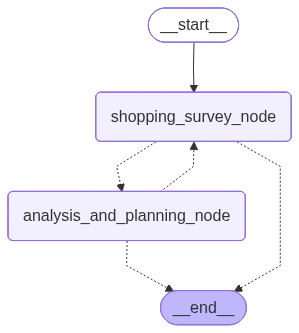

In [18]:
# 適応的調査の条件分岐関数
def should_continue_adaptive_survey(state: ShoppingSurveyState) -> str:
    """調査継続の判定"""

    # 最大回数超過の場合は終了
    if state["survey_iteration"] >= state["max_iterations"]:
        return END

    # 初回は`shopping_survey_node`
    if "current_process" not in state or not state["current_process"]:
        return "shopping_survey_node"

    # 現在の処理がある場合は、反対側の処理を実行
    if state["current_process"] == "shopping_survey_node":
        return "analysis_and_planning_node"

    elif state["current_process"] == "analysis_and_planning_node":
        # 継続フラグが False の場合は終了
        if not state["should_continue"]:
            return END
        return "shopping_survey_node"

    else:
        raise Exception(f"想定されないフローです: {state['current_process']}")


# LangGraphワークフロー構築
workflow = StateGraph(ShoppingSurveyState)

# ノードの追加
workflow.add_node("shopping_survey_node", shopping_survey_node)
workflow.add_node("analysis_and_planning_node", analysis_and_planning_node)

# ワークフローの定義
workflow.set_entry_point("shopping_survey_node")

# 調査実行後は必ず分析へ
workflow.add_conditional_edges(
    "shopping_survey_node",
    should_continue_adaptive_survey,
    {"analysis_and_planning_node": "analysis_and_planning_node", END: END},
)

# 分析後は継続判定に基づいて次回調査または終了
workflow.add_conditional_edges(
    "analysis_and_planning_node",
    should_continue_adaptive_survey,
    {"shopping_survey_node": "shopping_survey_node", END: END},
)

# メモリ設定
memory = MemorySaver()

# グラフコンパイル
adaptive_survey_app = workflow.compile(checkpointer=memory)

print("🔧 適応的ショッピング施設調査LangGraphワークフロー構築完了")
print("\n📊 ワークフロー構成:")
print("  🔍 調査実行 → 🧠 分析＆戦略立案 → 📋 継続判定 → ループまたは終了")

Image(adaptive_survey_app.get_graph(xray=True).draw_mermaid_png())

In [19]:
station_name = "大井町"
max_iterations = 2
initial_state = {
    "station_name": station_name,
    "max_iterations": max_iterations,
    "survey_iteration": 0,
    "messages": [HumanMessage(content=f"{station_name}の適応ショッピング施設調査を開始してください")],
}
config = {"configurable": {"thread_id": f"{station_name}-adaptive-shopping-survey"}}

result = adaptive_survey_app.invoke(initial_state, config)

🔍 SNS特化ショッピング施設エリア調査実行ノード開始 (第1回)
  📋 調査クエリ: 大井町周辺のショッピング施設が集まるエリア・商店街・ショッピングストリートを調査。SNS映えするエリアを優先し、各エリア内の代表施設情報も含めて収集
  📍 重点エリア: 大井町駅周辺全般
   除外条件: なし
  🔍 ショッピング施設エリア検索完了: 
    - 発見エリア数: 1
    - 検索カバレッジ: 大井町駅東口エリア
    - 除外条件適用: いいえ
    - データ信頼性: 高
  📝 調査サマリー生成完了: 
    - 新規発見店舗数: 1
    - 新規発見エリア: [ShoppingArea(area_name='大井町駅東口エリア', walking_minutes_range='3-7分', main_categories=['スーパー', 'ドラッグストア', '日用品店', '商店街'], area_characteristics='大井町駅東口から徒歩5分以内に日常消費をカバーする大型チェーンと個店が混在して集積。チェーン店の利便性と商店街の地元性が同居しており、短時間で複数の撮影テーマ（食・暮らし・夜景）を回れる動線が形成されています。', sns_highlights=['東急ストア前の広場で開催される季節ごとのイベント（フォトスポットとしての設えが明確）', '商店街のアーケードが夜にライトアップされるナイトフォトの訴求力'], instagrammable_spots=['東急ストア前の広場（ステージ・フード出店・人のいる風景が撮りやすい）', '商店街のアーケード（アーチと灯りを活かした縦構図の夜景）'], shopping_facilities=[ShoppingFacility(name='東急ストア 大井町店', category='スーパー', walking_minutes=3, location='大井町駅東口から徒歩3分', area_name='大井町駅東口エリア', features=['24時間営業', '新鮮な食材が豊富', 'ベーカリーコーナーあり'], price_range='中', business_hours='24時間営業', sns_appeal_points=['24時間営業ゆえに深夜

In [20]:
def introduce_shopping_areas(station_name: str, areas: List[ShoppingArea]) -> None:
    """発見したショッピング施設エリア情報を紹介する"""

    areas_summary = "\n,".join(
        [
            json.dumps(area.model_dump(), indent=2, ensure_ascii=False).replace("{", "{{").replace("}", "}}")
            for area in areas
        ]
    )

    llm = ChatOpenAI(model="gpt-5-mini", temperature=0)

    summary_prompt = ChatPromptTemplate.from_messages(
        [
            (
                "system",
                """あなたは駅周辺のショッピング施設エリア紹介のエキスパートです。
以下のショッピング施設エリア情報を基に、各エリアの魅力を引き出すSNSテロップ文を作成してください。
            """,
            ),
            (
                "user",
                f"""以下の駅「{station_name}」周辺のショッピング施設エリア情報を紹介してください：
```json
{areas_summary}```

注意点:
- 各エリアの特徴や雰囲気を具体的に描写
- SNS映えするスポットやメニューを強調
- 読者が訪れたくなるような魅力的な表現を使用
- 重複エリアはまとめて紹介してください

出力形式:
- キャッチフレーズ（駅名と特徴がわかる短いフレーズ）
- 各エリアの紹介文（テロップでスムーズに流れるような文章）
            """,
            ),
        ]
    )

    chain = summary_prompt | llm
    result = chain.invoke({})

    return result

In [21]:
intro = introduce_shopping_areas(station_name, result["discovered_areas"])

In [22]:
intro.pretty_print()

================================== Ai Message ==================================

キャッチフレーズ
大井町 —— 日常も映える、昼夜で表情が変わる“撮れる”街。

大井町駅東口エリア（徒歩3〜7分）
- 駅から徒歩5分以内にチェーンと個店が軒を連ねる、生活感とフォトジェニックが同居するエリア。
- 東急ストア前の広場は季節イベントのフォトスポット。ステージやフード出店のある“人がいる風景”が絵になります。
- 24時間営業の東急ストアは深夜・早朝のライフスタイル投稿に最適。ベーカリーや鮮魚コーナーの素材写真も映える！
- 商店街のアーケードは夜にライトアップ。アーチと灯りを生かした縦構図のナイトフォトが狙い目。
- 短時間で「食・暮らし・夜景」テーマを回せる動線で、撮影散歩にぴったり。

大井町駅西口エリア（徒歩3〜12分）
- 昼はカフェとスイーツ、夜は居酒屋・バーと表情を変える“撮れる”エリア。店内装飾や外観の個性が強いのが魅力。
- カフェ・ド・ランブルのテラスは昼の柔らかい光と路地の背景で人物が引き立つショットに最適。季節限定メニューはストーリー向け。
- アパレルショップ・リトルブルームのユニークな試着室はファッションリールや着回し投稿の鉄板スポット。
- 体験型店舗アートラボは“手元ショット”や完成品のビフォーアフターが映える。ワークショップの参加風景は拡散力抜群。
- 昼〜夜で被写体が変わるから、時間帯を変えて回遊すればコンテンツの幅が一気に広がるエリア。


In [27]:
result["discovered_areas"]

[ShoppingArea(area_name='大井町駅東口エリア', walking_minutes_range='3-7分', main_categories=['スーパー', 'ドラッグストア', '日用品店', '商店街'], area_characteristics='大井町駅東口から徒歩5分以内に日常消費をカバーする大型チェーンと個店が混在して集積。チェーン店の利便性と商店街の地元性が同居しており、短時間で複数の撮影テーマ（食・暮らし・夜景）を回れる動線が形成されています。', sns_highlights=['東急ストア前の広場で開催される季節ごとのイベント（フォトスポットとしての設えが明確）', '商店街のアーケードが夜にライトアップされるナイトフォトの訴求力'], instagrammable_spots=['東急ストア前の広場（ステージ・フード出店・人のいる風景が撮りやすい）', '商店街のアーケード（アーチと灯りを活かした縦構図の夜景）'], shopping_facilities=[ShoppingFacility(name='東急ストア 大井町店', category='スーパー', walking_minutes=3, location='大井町駅東口から徒歩3分', area_name='大井町駅東口エリア', features=['24時間営業', '新鮮な食材が豊富', 'ベーカリーコーナーあり'], price_range='中', business_hours='24時間営業', sns_appeal_points=['24時間営業ゆえに深夜・早朝のライフスタイル投稿が可能', 'ベーカリーや鮮魚コーナーはフード撮影で映える素材が揃う'], source_url='https://www.tokyu-store.co.jp/store/ooimachi/')]),
 ShoppingArea(area_name='大井町西口エリア', walking_minutes_range='3-12分（補足確認で8-15分圏も確認）', main_categories=['居酒屋・バー・カフェ・スイーツ・アパレル・雑貨・体験型店舗'], area_characteristics='大井町西口を中心とした徒歩圏内に、昼はカフェ・雑貨、夕方